[![image.png](https://i.postimg.cc/RhYr7Yv1/image.png)](https://postimg.cc/Zv6DZVB0)

<div style="padding:20px 30px 30px; 
            color:#004346;
            font-size:40px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 
<p style="font-weight: bold; text-align: center;">Прогнозирование температуры звезды</p>


</div>

<div style="padding:0px 40px 30px; 
            color:#004346;
            font-size:110%;
            display:fill;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:450;"> 
    
__Заказчик:__ обсерватория «Небо на ладони».
    
__Постановка задачи:__ разработка метода определения температуры на поверхности обнаруженных звёзд с использованием нейросетевого подхода.
    
__Описание задачи:__ необходимо создать модель нейронной сети, способную определять температуру на поверхности обнаруженных звёзд на основе доступных данных. Для этого требуется подготовить набор данных, содержащий информацию о различных характеристиках звёзд и соответствующие им измеренные значения температуры. Затем следует обучить нейросеть на этом наборе данных, чтобы она могла выявить закономерности и установить связь между входными параметрами и целевыми значениями температуры.    

__Оценка результата:__ В данной задаче мы можем использовать метрику RMSE (Root Mean Square Error) для оценки качества модели. Цель состоит в том, чтобы минимизировать значение RMSE и добиться, чтобы оно не превышало 4500. RMSE представляет собой квадратный корень из среднеквадратичной ошибки между прогнозируемыми и фактическими значениями температуры.
    
__Описание данных:__
    
В базе обсерватории есть данные о 240 звёзд:
    
- `Luminosity(L/Lo)` - Относительная светимость — светимость звезды относительно Солнца.
- `Radius(R/Ro)` - Относительный радиус — радиус звезды относительно радиуса Солнца.
- `Absolute magnitude(Mv)` — Абсолютная звёздная величина — физическая величина, характеризующая блеск звезды.
- `Star color` — Звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа.
- `Star type` — Тип звезды:
    | Тип звезды | Номер, соответствующий типу |
    | ------ | -------------- |
    | Коричневый карлик | 0  |
    | Красный карлик	 | 1 |
    | Белый карлик	 | 2  |
    | Звёзды главной последовательности	 | 3 |
    | Сверхгигант | 4 |
    | Гипергигант | 5 |


____________________

__Целевой признак:__ 
- `Temperature (K)` - Абсолютная температура — температура на поверхности звезды в Кельвинах.

</div>    

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Используемые библиотеки

</div>

In [43]:
!pip install skorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 221.3/221.3 kB 1.1 MB/s eta 0:00:00a 0:00:01


In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik

from sklearn.model_selection import train_test_split
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset
from torch.utils.data import DataLoader

from sklearn.metrics import mean_squared_error
from math import sqrt

#from sklearn.model_selection import ParameterGrid

from skorch.callbacks import EpochScoring, EarlyStopping
from skorch.dataset import ValidSplit
from skorch import NeuralNetRegressor

from sklearn.metrics import make_scorer
from sklearn.model_selection import cross_val_score
import optuna

# константы
RANDOM_SEED = 42

# настройки блокнота
torch.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Загрузка данных

</div>

In [2]:
# загрузка данных:
try:
    df = pd.read_csv('data/stars.csv')
    display(df.head(2))
except:
    display('Данные не доступны')

,Unnamed: 0,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,0,3068,0.0024,0.1700,16.12,0,Red
1,1,3042,0.0005,0.1542,16.60,0,Red


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Предобработка и исследовательский анализ данных

## Общая информация

</div>

In [3]:
display(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 7 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Unnamed: 0              240 non-null    int64  
 1   Temperature (K)         240 non-null    int64  
 2   Luminosity(L/Lo)        240 non-null    float64
 3   Radius(R/Ro)            240 non-null    float64
 4   Absolute magnitude(Mv)  240 non-null    float64
 5   Star type               240 non-null    int64  
 6   Star color              240 non-null    object 
dtypes: float64(3), int64(3), object(1)
memory usage: 13.2+ KB


None

__Проверим пропуски в данных:__

In [4]:
print(f'Общее количество пропусков в данных: {sum(col_pas for col_pas in df.isna().sum())}')

Общее количество пропусков в данных: 0


<div style="padding: 30px 25px; border: 2px #6495ed solid">

- Данные загружены корректно.
- Пропуски в данных отсутствуют.
    
__Недостатки:__
- Некоректное названий стобцов, их следует переименовать;
- В датафрейме присутствует признак `Unnamed: 0`, наличие которого связано с импортом индексов датафрейма, при его сохранении, его следует удалить.
    
</div>

### Удаление признака `Unnamed: 0`

In [5]:
df = df.drop('Unnamed: 0', axis=1).copy()

### Переименование признаков

In [6]:
# создание словаря с новыми именами столбцов
new_column_names = {
    "Temperature (K)": "temperature",
    "Luminosity(L/Lo)": "luminosity",
    "Radius(R/Ro)": "radius",
    "Absolute magnitude(Mv)": "magnitude_abs",
    "Star type": "type",
    "Star color": "color",
}
# переименование столбцов
df = df.rename(columns=new_column_names)

# вывод датасета с переименованными столбцами
display(df.head(2))

,temperature,luminosity,radius,magnitude_abs,type,color
0,3068,0.0024,0.1700,16.12,0,Red
1,3042,0.0005,0.1542,16.60,0,Red


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Дубликаты
    
</div>

In [7]:
print(f'Количество дубликатов в данных:{df.duplicated().sum()}')

Количество дубликатов в данных:0


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ категориальные признаков
    
</div>

__Общая информация:__

In [8]:
display(df.describe(include=[object]))

,color
count,240
unique,19
top,Red
freq,112


In [9]:
df['type'].value_counts()

0    40
1    40
2    40
3    40
4    40
5    40
Name: type, dtype: int64

__Посмотрим уникальные значения в категориальных признаках:__

In [10]:
print(f'Уникальные значения признака color в данных:\n{df["color"].unique()}')

Уникальные значения признака color в данных:
['Red' 'Blue White' 'White' 'Yellowish White' 'Blue white'
 'Pale yellow orange' 'Blue' 'Blue-white' 'Whitish' 'yellow-white'
 'Orange' 'White-Yellow' 'white' 'Blue ' 'yellowish' 'Yellowish'
 'Orange-Red' 'Blue white ' 'Blue-White']


<div style="padding: 30px 25px; border: 2px #6495ed solid">
    

- Категориальный столбец `type` содержит равное количество записей для каждого типа звезд, что свидетельствует о том, что этот признак является репрезентативным.

    __Недостатки признака `color`:__
- Встречаются записи одного и того же цвета, но в разных регистрах.
- Также наблюдаются одинаковые записи цвета с использованием различных разделителей и пробелов.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

### Обработка категориальных признаков
    
</div>

In [11]:
# перевод записей в нижний регистр
df['color'] = df['color'].str.lower()
# стандартизация разделителей
df['color'] = df['color'].str.replace('-', ' ')
# удаление лишних пробельных символов
df['color'] = df['color'].str.strip()

In [12]:
df["color"].unique()

array(['red', 'blue white', 'white', 'yellowish white',
       'pale yellow orange', 'blue', 'whitish', 'yellow white', 'orange',
       'white yellow', 'yellowish', 'orange red'], dtype=object)

__Рассмотрим распределение количества записей в зависимости от значения признака `color`:__

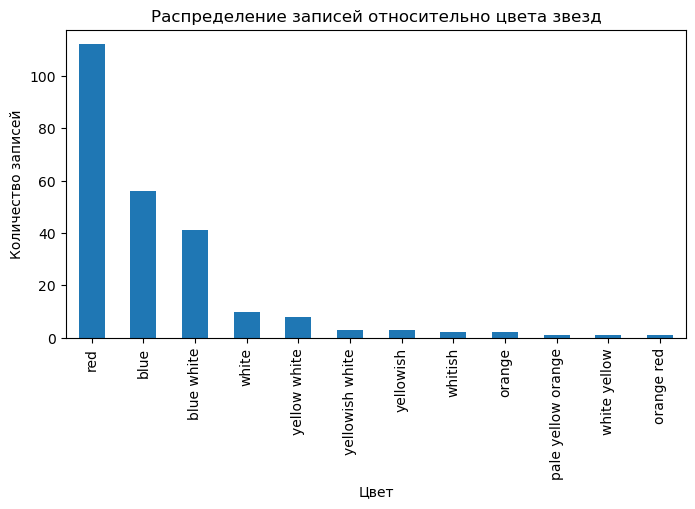

In [13]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
 
Исходя из графика, видно, что количество записей относительно разных цветов распределено неравномерно. Чтобы исправить это, предлагается объединить схожие записи цветов. В рамках этой коррекции, следующие группы цветов будут объединены:

- Желтый (yellow) будет включать:

     - Yellowish white
     - Yellow white
     - Yellowish
     - Pale yellow orange
    
- Белый (white) будет включать:

     - White
     - Whitish
     - White yellow
    
- Оранжевый (orange) будет включать:
    
     - Orange
     - Orange red
    
Такое объединение цветов основано на том, что в названии цветов более доминирующий цвет указывается слева относительно записи. Это позволит учесть близкие оттенки цветов и сгруппировать их в более общие категории для улучшения репрезентативности и удобочитаемости данных.
</div>

In [14]:
# создание словаря
replace_color = {
    "yellowish white": "yellow",
    "yellow white": "yellow",
    "yellowish": "yellow",
    "pale yellow orange": "yellow",
    "whitish": "white",
    "white yellow": "white",
    "orange red": "orange",
}
# укрепление групп
df["color"] = df["color"].replace(replace_color).copy()

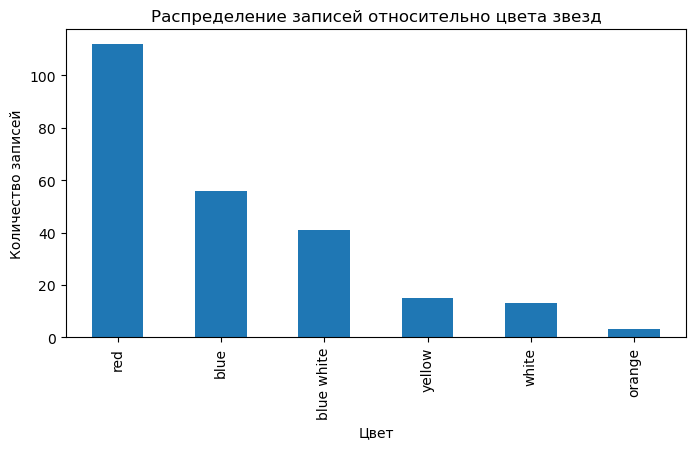

In [15]:
# подсчет количества записей по каждому цвету
fig, ax = plt.subplots(figsize=(8, 4)) 
df['color'].value_counts().plot(kind='bar', ax=ax)
plt.xlabel('Цвет')
plt.ylabel('Количество записей')
plt.title('Распределение записей относительно цвета звезд')
# отображение графика
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- Из графика видно, что распределение количества записей стало более сбалансированным после объединения схожих записей цветов. Однако все же остается небольшое количество записей с значением "orange" по сравнению с другими группами цветов. Это важное наблюдение, которое следует учесть при дальнейшем анализе данных.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

## Анализ числовых признаков
    
</div>

In [16]:
# общая информация
df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].describe().T

,count,mean,std,min,25%,50%,75%,max
temperature,240.0,10497.462500,9552.425037,1939.00000,3344.250000,5776.0000,15055.5000,40000.00
luminosity,240.0,107188.361635,179432.244940,0.00008,0.000865,0.0705,198050.0000,849420.00
radius,240.0,237.157781,517.155763,0.00840,0.102750,0.7625,42.7500,1948.50
magnitude_abs,240.0,4.382396,10.532512,-11.92000,-6.232500,8.3130,13.6975,20.06


- Данные имеют большое стандартное отклонение, что указывает на значительную вариативность.
- Явных аномалий в числовых данных нет.

__Посмотрим на распределения данных__

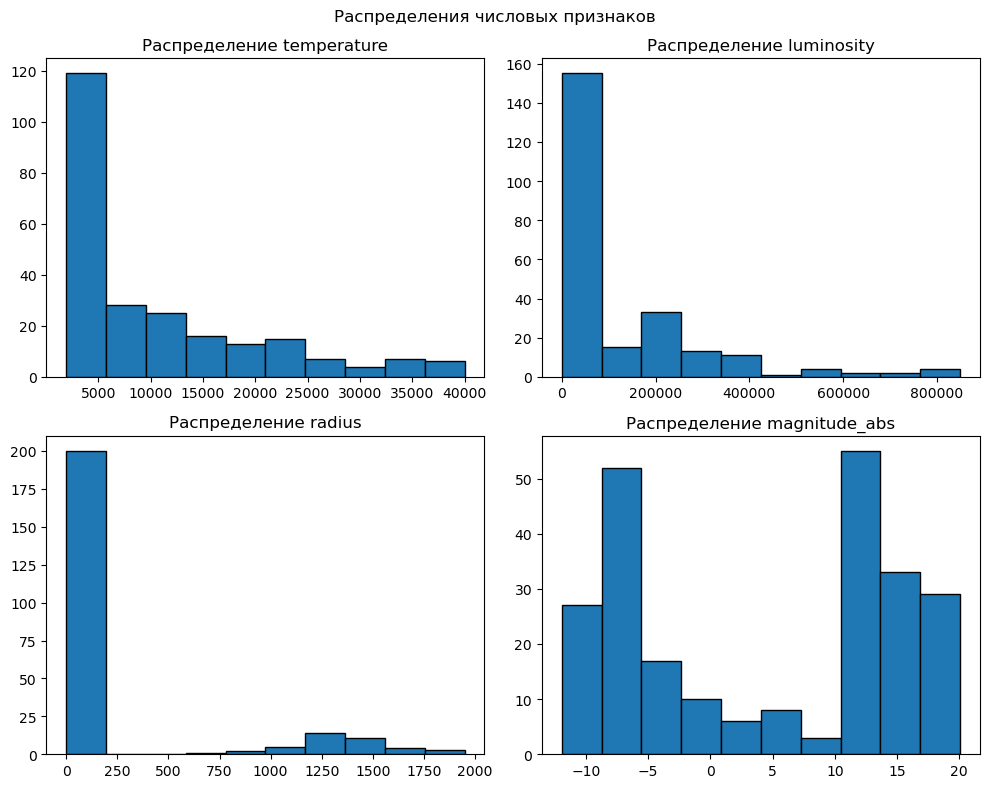

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(10, 8)) 
# гистограмма для 'temperature'
axes[0, 0].hist(df['temperature'], bins=10, edgecolor='black')
axes[0, 0].set_title('Распределение temperature')
# гистограмма для 'luminosity'
axes[0, 1].hist(df['luminosity'], bins=10, edgecolor='black')
axes[0, 1].set_title('Распределение luminosity')
# гистограмма для 'radius'
axes[1, 0].hist(df['radius'], bins=10, edgecolor='black')
axes[1, 0].set_title('Распределение radius')
# гистограмма для 'magnitude_abs'
axes[1, 1].hist(df['magnitude_abs'], bins=10, edgecolor='black')
axes[1, 1].set_title('Распределение magnitude_abs')

plt.suptitle('Распределения числовых признаков')

plt.tight_layout()
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
- На графиках 'temperature', 'luminosity', 'radius' видно, что распределение ассимитрично вправо, что визуально подтверждает, табличные данные о большом значении стандартного отклонения.
- Так же стоит отметить схожесть графиков, что может быть признаком линейных зависимостей между этими признаками. Таким образом, светимость, возможно, достаточно точно отражает как и энергию звезды, так и ее радиус.
- Абсолютная звёздная величина, график magnitude_abs, имеет симметричное увеличение в обе стороны, что говорит о нисзком количестве схожиж звезд, по данному показателю, среди изученных
</div>

### Корреляции между числовыми признаками

__Линейные взаимосвязи числовых данных__

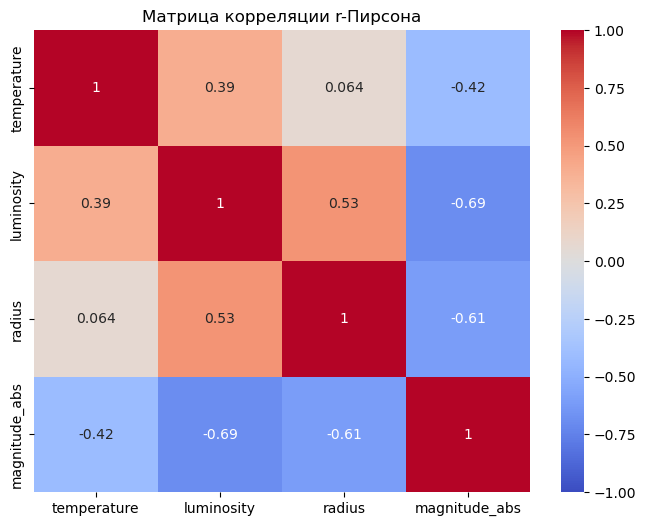

In [18]:
corr_matrix = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].corr()
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Матрица корреляции r-Пирсона')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
Предоставленные данные указывают на наличие линейных зависимостей между некоторыми признаками. В частности, обнаружены следующие линейные связи:

- Между температурой и светимостью: Коэффициент корреляции равен 0.39. Это указывает на положительную линейную зависимость между этими двумя признаками. При увеличении температуры возможно увеличение светимости, хотя сила и направление этой зависимости могут быть ограничены.

- Между светимостью и радиусом: Коэффициент корреляции равен 0.53. Это также указывает на положительную линейную зависимость между светимостью и радиусом. Большая светимость может быть связана с более большим радиусом звезды, хотя здесь также могут существовать другие факторы, влияющие на эту зависимость.

Учет этих линейных связей между признаками позволяет лучше понять физические свойства и характеристики звезд. Однако стоит отметить, что линейные связи не всегда являются единственными или полными моделями взаимосвязи между признаками, и возможно наличие иных более сложных взаимосвязей, которые следует учитывать в дальнейшем анализе.
</div>

In [19]:
phik_overview = df[['temperature', 'luminosity', 'radius', 'magnitude_abs']].phik_matrix()
display(phik_overview)

interval columns not set, guessing: ['temperature', 'luminosity', 'radius', 'magnitude_abs']


,temperature,luminosity,radius,magnitude_abs
temperature,1.000000,0.561692,0.236090,0.709280
luminosity,0.561692,1.000000,0.574964,0.709456
radius,0.236090,0.574964,1.000000,0.512414
magnitude_abs,0.709280,0.709456,0.512414,1.000000


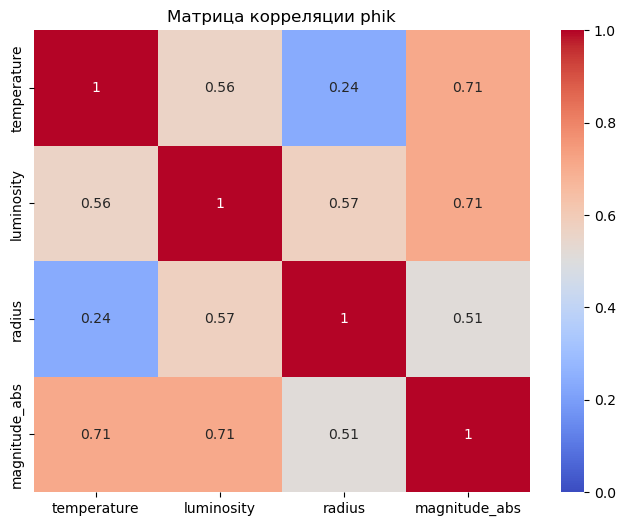

In [20]:
# heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(phik_overview, annot=True, cmap='coolwarm', vmin=0, vmax=1)
plt.title('Матрица корреляции phik')

plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">

Согласно предоставленным данным, наблюдаются сильные нелинейные взаимосвязи между различными признаками, такими как температура, светимость, радиус и абсолютная величина звезд.

Присутствие таких нелинейных взаимосвязей подтверждает потенциал использования алгоритмов нейросетей для определения температуры на поверхности обнаруженных звезд. Нейронные сети могут эффективно обнаруживать и моделировать сложные нелинейные взаимосвязи в данных и строить предсказательные модели, которые учитывают эти взаимосвязи. Это позволяет получить более точные и надежные прогнозы температуры на основе других характеристик звезды.

Однако важно отметить, что выбор и конфигурация алгоритмов нейросетей требует тщательного исследования, обучения и оптимизации. Это поможет достичь наилучших результатов и гарантировать, что модель нейросети адекватно учитывает нелинейные взаимосвязи в данных для определения температуры на поверхности звезд.
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Подготовка данных к построению модели
    
</div>

- Разделение данных: Разделим данные на тренировочную и тестовую выборки. Поскольку у вас ограниченное количество наблюдений, оставить 20% данных для тестирования модели, а остальные 80% используем для обучения модели.
- Нормализация числовых данных: Произведем нормализацию числовых данных, чтобы все признаки имели сопоставимые диапазоны значений. Нормализация поможет стабилизировать обучение модели и предотвратить преимущественное влияние признаков с большими значениями.
- Преобразование категориальных данных в унитарный код: Категориальные данные, такие как цвет или тип звезды, необходимо преобразовать в унитарный код (one-hot encoding). Это позволит представить каждое категориальное значение в виде бинарного вектора, где каждый столбец соответствует определенной категории. Такое представление позволит модели учиться на категориальных данных.

## Выделение обучающей и тестовой выборок

In [21]:
X = df.drop('temperature', axis=1)
y = df['temperature'] # целевой признак

In [22]:
# формирование выборок
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
# проверка размерности выборок
for x in ['X_train', 'X_test', 'y_train', 'y_test']:
    print(f'Размерность {x}: {globals()[x].shape} - {len(globals()[x])/len(df):.0%}')

Размерность X_train: (192, 5) - 80%
Размерность X_test: (48, 5) - 20%
Размерность y_train: (192,) - 80%
Размерность y_test: (48,) - 20%


## Нормализация входных данных

In [24]:
categorical_columns = ["type", "color"]
numeric_columns = ["luminosity", "radius", "magnitude_abs"]

col_transformer = ColumnTransformer(
    transformers=[
        ("scaler", StandardScaler(), numeric_columns), # преобразование числовых данных
        ("ohe", OneHotEncoder(sparse_output=False), categorical_columns), # преобразование категориальных данных
    ],
    remainder="passthrough",
    n_jobs=-1
)
# преобразование данных
X_train = col_transformer.fit_transform(X_train)
X_test = col_transformer.transform(X_test)

## Создание тензеров

In [25]:
# преобразование выборок в тензоры
X_train_tensor = torch.Tensor(X_train)
X_test_tensor = torch.Tensor(X_test)
y_train_tensor = torch.Tensor(y_train.values)
y_test_tensor = torch.Tensor(y_test.values)
# проверка размерности тензоров
for x in ['X_train_tensor', 'X_test_tensor', 'y_train_tensor', 'y_test_tensor']:
    print(f'Размерность {x}: {globals()[x].shape}')

Размерность X_train_tensor: torch.Size([192, 15])
Размерность X_test_tensor: torch.Size([48, 15])
Размерность y_train_tensor: torch.Size([192])
Размерность y_test_tensor: torch.Size([48])


<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Построение простой модели нейронной сети — baseline
    
</div>

__Архитектура нейронной сети:__

1 Входной слой:

   - Размерность входных данных определяется переменной input_size и равен количеству признаков.
   - Этот слой представлен в виде линейного слоя (nn.Linear), который принимает входные данные и производит линейную трансформацию с помощью весов и смещения.
   
2 Скрытые слои:

   - В данной архитектуре нейронной сети используем три скрытых слоя.
   - Каждый скрытый слой состоит из линейного слоя (nn.Linear), за которым следует функция активации.
   - Функции активации, используемые в этой архитектуре, определяются переменными activation_1, activation_2, activation_3, activation_4.
   - Добавление техники регуляризации Dropout, поможет улучшить обобщающую способность нейронной сети и снизит риск переобучения, вероятности выключения нейронов в слоях определяются переменными drop_1, drop_2, drop_3, drop_4. В baseline-модели данную технику применим только к первому слою, затем подберем опримальные параметры для этого и остальных слоев.
   - Размеры скрытого слоя определяются переменными hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4.
   
3 Выходной слой:

   - Выходной слой представлен линейным слоем (nn.Linear), который преобразует выходные значения скрытых слоев в одно число.
   - В данном случае, поскольку решается задача регрессии, выходной слой имеет размерность 1 и задается переменной output_size.
   
4 Инициализация весов:
   - Инициализацию весов будем производить с помощью метода Kaiming, что может помочь ускорить процесс обучения и предотвратить затухания/взрыва градиента.

In [123]:
# определение архитектуры нейронной сети
class Baseline(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4):
        super(Baseline, self).__init__()\
        
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.act1 = activation_1
        self.drop1 = nn.Dropout(drop_1)
        
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.act2 = activation_2
        self.drop2 = nn.Dropout(drop_2)
        
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.act3 = activation_3
        self.drop3 = nn.Dropout(drop_3)
        
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.act4 = activation_4
        self.drop4 = nn.Dropout(drop_4)
        
        self.fc5 = nn.Linear(hidden_size_4, output_size)
        
        self.init_weights()
        
    def forward(self, x):
        x = self.drop1(self.act1(self.fc1(x)))
        x = self.drop2(self.act2(self.fc2(x)))
        x = self.drop3(self.act3(self.fc3(x)))
        x = self.drop4(self.act4(self.fc4(x)))
        x = self.fc5(x)
        return x
    
    def init_weights(m):
        if isinstance(m, nn.Linear):
            torch.nn.init.kaiming_normal_(m.weight)
            m.bias.data.fill_(0.01)

- Для создания пакетов (batch) используем Dataloader, предоставляющий удобный способ загрузки и предварительной обработки данных во время обучения моделей машинного обучения. Данный компонент PyTorch позволяет настраивать различные параметры для загрузки данных, такие как размер пакета (batch size), количество рабочих процессов для параллельной загрузки данных (num_workers), случайное перемешивание данных (shuffle) 

In [124]:
# класс для создания пакетов
class Batch(Dataset):
  def __init__(self, data, labels):
    self.labels = labels
    self.data = data

  def __len__(self):
    return len(self.labels)

  def __getitem__(self, idx):
    label = self.labels[idx]
    data = self.data[idx]
    sample = {'data': data, 'temperature': label}
    return sample

In [125]:
dataset_train = Batch(X_train_tensor, y_train_tensor)
dataset_test = Batch(X_test_tensor, y_test_tensor)

In [126]:
# параметры Baseline нейронной сети

# размер слоев
input_size = X_train_tensor.shape[1]  
hidden_size_1 = 50  
hidden_size_2 = 40  
hidden_size_3 = 5  
hidden_size_4 = 45  
output_size = 1 
# функции активации
activation_1 = nn.ReLU()
activation_2 = nn.Tanh()
activation_3 = nn.ReLU()
activation_4 = nn.LeakyReLU()
# вероятности выключения нейроны в слое
drop_1 = 0.1
drop_2 = 0.0
drop_3 = 0.0
drop_4 = 0.0

learning_rate = 0.01  # скорость обучения
n_epochs = 1000  # количество эпох обучения
batch_size = 32  # размер пакета

In [127]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)
# функция потерь
loss = nn.MSELoss()
# оптимизатор
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
# пакеты (batch)
train_dataloader = DataLoader(dataset_train, batch_size=batch_size, shuffle=True,
                              num_workers=0)
test_dataloader = DataLoader(dataset_test, batch_size=batch_size, num_workers=0)

__Ранняя остановка__

Чтобы не подбирать коливо эпох и при этом избежать переобучения, воспользуемся ранней остановкой, для этого напишем класс для ее реализации.

In [128]:
class CustomEarlyStopping():
    """
    Ранняя остановка: остановить тренировку, если функция потерь не улучшается после определенного количества эпох.
    """
    def __init__(self, patience=5, min_delta=0):
        """
        :param patience: сколько эпох ждать, прежде чем остановиться
        :param min_delta: минимальная разница функций потерь для активации param patience
        """
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False

    def __call__(self, val_loss):
        if self.best_loss == None:
            self.best_loss = val_loss
        elif self.best_loss - val_loss > self.min_delta:  # обновление значения функция потерь при улучшении
            self.best_loss = val_loss 
            self.counter = 0
        elif self.best_loss - val_loss < self.min_delta:  # счетчик patience при ухудшении функция потерь
            self.counter += 1
            #print(f'INFO: C ранней остановки {self.counter}/{self.patience}')
            if self.counter >= self.patience:
                print(f'INFO: Ранняя остановка. Счетчик: {self.counter}/{self.patience}')
                self.early_stop = True  # остановка обучения при достижении максимума счетсика patience

__Функция для обучения__

In [129]:
def train(model, train_dataloader, test_dataloader, optimizer, loss, n_epochs, patience, min_delta):
    
    result = {'rmse_train': [],
             'rmse_test': [],
             'best_epoch': None,
             'stopping_epoch': None,
             'best_model': None}
    
    early_stopping = CustomEarlyStopping(patience, min_delta)
    for epoch in range(n_epochs):
        # обучение
        model.train()
        total_loss = 0.0
        for batch in train_dataloader:
            data = batch['data']
            label_train = batch['temperature']
            
            optimizer.zero_grad()
            
            predictions = model.forward(data).flatten()
            loss_value = loss(predictions, label_train)
            total_loss += loss_value.item()
            
            loss_value.backward()
            optimizer.step()
            
        rmse_tr = sqrt(total_loss/len(train_dataloader))
        result['rmse_train'].append(rmse_tr)
        
        # тестирование
        model.eval()
        total_loss = 0.0
        with torch.no_grad(): # отключаем вычисление градиентов
            for batch in test_dataloader:
                data = batch['data']
                label_test = batch['temperature']
                
                predictions = model.forward(data).flatten()
                loss_value = loss(predictions, label_test)
                total_loss += loss_value
            rmse_ts = sqrt(total_loss/len(train_dataloader))
            result['rmse_test'].append(rmse_ts)
            
        if epoch % 10 == 0 or epoch == n_epochs - 1:    
             print(f'Epoch: {epoch} RMSE_train: {round(rmse_tr)} RMSE_test: {round(rmse_ts)}')
        
        early_stopping(rmse_ts)
        if early_stopping.counter == 1:
            result['best_model'] = model
        if early_stopping.early_stop:
            result['best_epoch'] = epoch-patience
            result['stopping_epoch'] = epoch
            print(f"Best epoch: {epoch-patience} RMSE_train: {round(result['rmse_train'][-patience])} RMSE_test: {round(result['rmse_test'][-patience])}")
            break
        if epoch == n_epochs-1:
            result['best_epoch'] = epoch
            result['stopping_epoch'] = epoch
            print(f'Best epoch: {epoch} RMSE_train: {round(rmse_train[-1])} RMSE_test: {round(rmse_test[-1])}')        
    return result

## Обучение baseline-модели

In [130]:
result = train(model=model,
               train_dataloader=train_dataloader,
               test_dataloader=test_dataloader,
               optimizer=optimizer,
               loss=loss,
               n_epochs=n_epochs,
               patience=20,
               min_delta=0)

Epoch: 0 RMSE_train: 13898 RMSE_test: 8066
Epoch: 10 RMSE_train: 13015 RMSE_test: 7466
Epoch: 20 RMSE_train: 9356 RMSE_test: 5546
Epoch: 30 RMSE_train: 5942 RMSE_test: 3475
Epoch: 40 RMSE_train: 4633 RMSE_test: 3511
Epoch: 50 RMSE_train: 4530 RMSE_test: 3319
INFO: Ранняя остановка. Счетчик: 20/20
Best epoch: 33 RMSE_train: 5075 RMSE_test: 3332


__График процесса обучения__

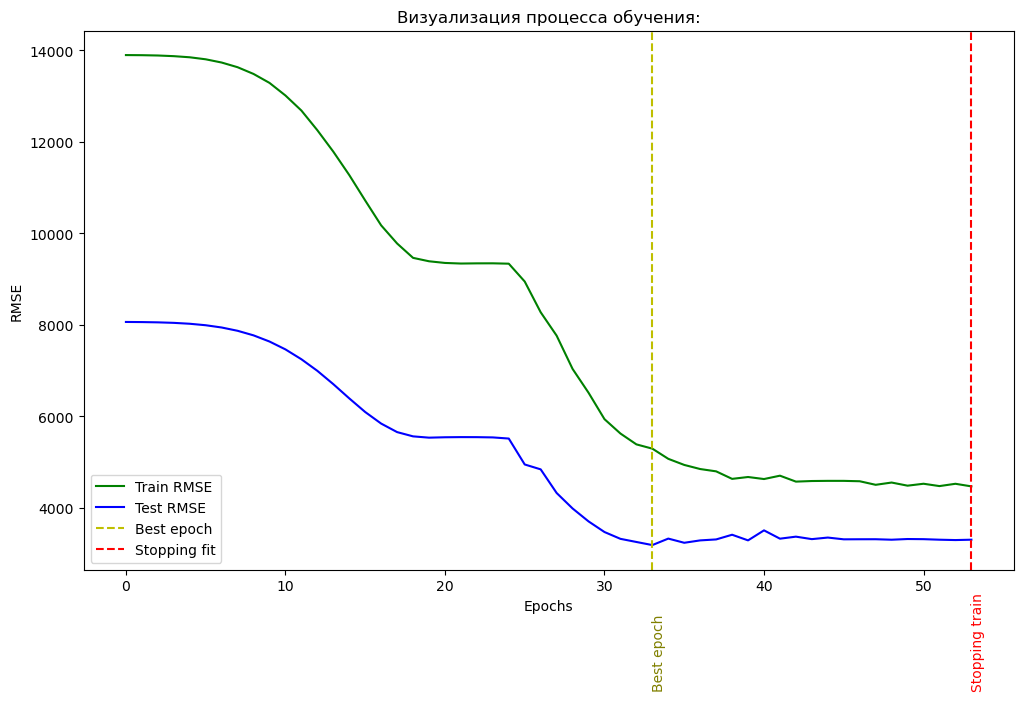

In [131]:
plt.figure(figsize=(12, 7))
plt.plot(result['rmse_train'], color='green', label='Train RMSE')
plt.plot(result['rmse_test'], color='blue', label='Test RMSE')

# отметка Best epoch
plt.axvline(x=result['best_epoch'], color='y', linestyle='--', label='Best epoch')
plt.text(result['best_epoch'], 0.9, 'Best epoch', color='olive', rotation=90, va='bottom')
# отметка Stopping train
plt.axvline(x=result['stopping_epoch'], color='red', linestyle='--', label='Stopping fit')
plt.text(result['stopping_epoch'], 0.9, 'Stopping train', color='red', rotation=90, va='bottom')

plt.title('Визуализация процесса обучения:')
plt.xlabel('Epochs')
plt.ylabel('RMSE')
plt.legend(loc='lower left')
plt.show()

__График "Факт - Прогноз" baseline-модели:__

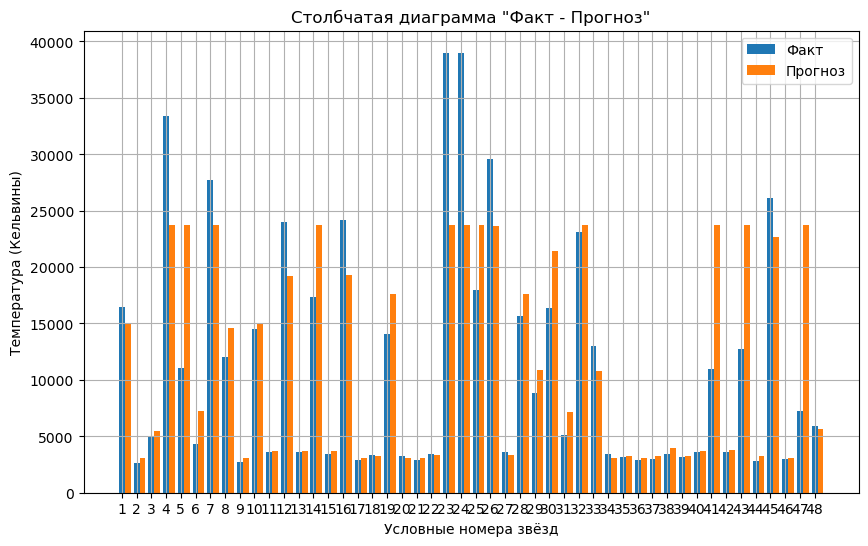

In [132]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = result['best_model'].forward(X_test_tensor).detach().numpy().flatten()
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(10, 6))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
    - Уровень качества baseline-модели, предсказывающей температуру звезд, достаточно хорош, учитывая метрики RMSE на тренировочной и тестовой выборках(). Однако, из графика "Факт - Прогноз" становится заметно, что модель имеет тенденцию предсказывать более усредненные значения температуры для наиболее горячих звезд.
    - Такое поведение можно объяснить низким количеством записей в данных. Относительно недостаточное количество наблюдений для наиболее горячих звезд может затруднять адекватное обучение модели для точного предсказания их температуры.
    - Для дальнейшего усовершенствования алгоритма, мы можем провести эксперименты с различными параметрами, такими как размер пакета обучения (batch size), вероятность выключения нейронов из обучения (dropout), функции активации в слоях и количество нейронов в слое. Это позволит настроить модель более оптимально для данной задачи и повысить точность предсказаний, даже при ограниченном количестве данных о звездах.
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Улучшение нейронной сети
    
</div>

- Для подбора оптимальных параметров используем __optuna__

In [133]:
# фукция для расчета RMSE
def rmse(y_true, y_pred):
    return mean_squared_error(y_true, y_pred, squared=False)

rmse_scorer = make_scorer(rmse)

In [134]:
def objective(trial):

    # dropout
    drop_1 = trial.suggest_float('module__drop_1', 0.0, 0.5, step=0.1)
    drop_2 = trial.suggest_float('module__drop_2', 0.0, 0.5, step=0.1)
    drop_3 = trial.suggest_float('module__drop_3', 0.0, 0.5, step=0.1)
    drop_4 = trial.suggest_float('module__drop_4', 0.0, 0.5, step=0.1)

    # функции активации
    activation_dict = {"nn.LeakyReLU()": nn.LeakyReLU(),
                       "nn.ReLU()": nn.ReLU(),
                       "nn.Tanh()": nn.Tanh(),
                       "nn.ELU()": nn.ELU()
                      }

    activation_1 = trial.suggest_categorical('module__activation_1', ["nn.LeakyReLU()", "nn.ReLU()", "nn.Tanh()", "nn.ELU()"])
    activation_2 = trial.suggest_categorical('module__activation_2', ["nn.LeakyReLU()", "nn.ReLU()", "nn.Tanh()", "nn.ELU()"])
    activation_3 = trial.suggest_categorical('module__activation_3', ["nn.LeakyReLU()", "nn.ReLU()", "nn.Tanh()", "nn.ELU()"])
    activation_4 = trial.suggest_categorical('module__activation_4', ["nn.LeakyReLU()", "nn.ReLU()", "nn.Tanh()", "nn.ELU()"])

    activation_1 = activation_dict.get(activation_1)
    activation_2 = activation_dict.get(activation_2)
    activation_3 = activation_dict.get(activation_3)
    activation_4 = activation_dict.get(activation_4)


    # количество нейронов
    input_size = X_train.shape[-1]
    output_size = 1

    hidden_size_1 = trial.suggest_int('module__hidden_size_1', 5, 60,  step=1)
    hidden_size_2 = trial.suggest_int('module__hidden_size_2', 5, 60,  step=1)
    hidden_size_3 = trial.suggest_int('module__hidden_size_3', 5, 60,  step=1)
    hidden_size_4 = trial.suggest_int('module__hidden_size_4', 5, 60,  step=1)



    # скорость обучения
    lr = trial.suggest_loguniform('learning_rate', 1e-6, 1e-0)
    weight_decay = trial.suggest_loguniform('learning_rate_weight_decay', 1e-6, 1e-0)

    # размер пакета обучения
    batch_size = trial.suggest_int('batch_size', 5, 120,  step=10)
    
    # модель
    model_base = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                          drop_1, drop_2, drop_3, drop_4,
                          activation_1, activation_2, activation_3, activation_4)
    
    # количество шагов до остановки обучения
    patience = trial.suggest_int('patience', 10, 60,  step=5)

    # параметры подбора параметров модели
    skorch_regressor = NeuralNetRegressor(module=model_base,
                                      device='cpu',
                                      verbose=0,
                                      optimizer__weight_decay=weight_decay,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam,
                                      max_epochs=2500,
                                      lr=lr,
                                      train_split=ValidSplit(cv=4),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience))
            ]
                                     )



    rmse = cross_val_score(skorch_regressor, X_train_tensor.numpy().astype('float32'),
                            y_train_tensor.numpy().astype('float32').reshape(-1,1),
                            n_jobs=-1,
                            cv=4,
                           scoring=rmse_scorer)
    rmse = abs(rmse.mean())
    return rmse

In [135]:
%%time
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=300)

[I 2023-07-19 17:14:40,991] A new study created in memory with name: no-name-d60e89f1-3cdd-4b42-81b5-439f12ce0b0e
/var/folders/1l/cj5j7tnj6q347f0pj242vpfm0000gn/T/ipykernel_36350/2699283441.py:39: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/var/folders/1l/cj5j7tnj6q347f0pj242vpfm0000gn/T/ipykernel_36350/2699283441.py:40: FutureWarning:

suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.

/Users/denismuhanov/miniconda3/lib/python3.10/site-packages/optuna/distributions.py:700: UserWarning:

The distribution is specified by [5, 120] and step=10, but the range is not divisible by `step`. It will be replaced by [5, 115].

[I 2023-07-19 17:14:42,569] Trial 0 finished with value: 13831.896972656

[I 2023-07-19 17:15:19,559] Trial 12 finished with value: 5249.179443359375 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 58, 'module__hidden_size_2': 60, 'module__hidden_size_3': 60, 'module__hidden_size_4': 17, 'learning_rate': 0.06111555509000278, 'learning_rate_weight_decay': 0.8357608547996824, 'batch_size': 105, 'patience': 30}. Best is trial 12 with value: 5249.179443359375.
[I 2023-07-19 17:15:19,836] Trial 13 finished with value: 4614.791015625 and parameters: {'module__drop_1': 0.5, 'module__drop_2': 0.4, 'module__drop_3': 0.0, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 60, 'module__hidd

[I 2023-07-19 17:15:22,876] Trial 26 finished with value: 4778.7425537109375 and parameters: {'module__drop_1': 0.4, 'module__drop_2': 0.0, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.4, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 55, 'module__hidden_size_2': 33, 'module__hidden_size_3': 30, 'module__hidden_size_4': 55, 'learning_rate': 0.036545180155122065, 'learning_rate_weight_decay': 0.019229357506615183, 'batch_size': 75, 'patience': 25}. Best is trial 18 with value: 4522.2120361328125.
[I 2023-07-19 17:15:25,439] Trial 27 finished with value: 10337.497192382812 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.2, 'module__drop_3': 0.1, 'module__drop_4': 0.5, 'module__activation_1': 'nn.ReLU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1

[I 2023-07-19 17:15:39,328] Trial 39 finished with value: 9390.450439453125 and parameters: {'module__drop_1': 0.5, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.5, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 36, 'module__hidden_size_2': 31, 'module__hidden_size_3': 56, 'module__hidden_size_4': 41, 'learning_rate': 0.048215905364722714, 'learning_rate_weight_decay': 0.040649731775003556, 'batch_size': 75, 'patience': 35}. Best is trial 18 with value: 4522.2120361328125.
[I 2023-07-19 17:15:39,519] Trial 40 finished with value: 6348.618896484375 and parameters: {'module__drop_1': 0.30000000000000004, 'module__drop_2': 0.1, 'module__drop_3': 0.0, 'module__drop_4': 0.4, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.ELU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation

[I 2023-07-19 17:15:44,052] Trial 52 finished with value: 4538.722229003906 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 20, 'module__hidden_size_2': 42, 'module__hidden_size_3': 35, 'module__hidden_size_4': 15, 'learning_rate': 0.025059672006952312, 'learning_rate_weight_decay': 0.0910510933713033, 'batch_size': 115, 'patience': 55}. Best is trial 45 with value: 4352.325439453125.
[I 2023-07-19 17:15:44,443] Trial 53 finished with value: 4371.046447753906 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 

[I 2023-07-19 17:15:51,577] Trial 65 finished with value: 4782.212707519531 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.5, 'module__drop_3': 0.0, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 28, 'module__hidden_size_2': 41, 'module__hidden_size_3': 25, 'module__hidden_size_4': 16, 'learning_rate': 0.00886211459075394, 'learning_rate_weight_decay': 0.48519036615901406, 'batch_size': 115, 'patience': 45}. Best is trial 62 with value: 4277.2984619140625.
[I 2023-07-19 17:15:52,035] Trial 66 finished with value: 4724.024475097656 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.0, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 22, '

[I 2023-07-19 17:16:11,715] Trial 78 finished with value: 9346.601928710938 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 21, 'module__hidden_size_2': 39, 'module__hidden_size_3': 41, 'module__hidden_size_4': 25, 'learning_rate': 0.07726689589815541, 'learning_rate_weight_decay': 0.4568446415555572, 'batch_size': 115, 'patience': 60}. Best is trial 62 with value: 4277.2984619140625.
[I 2023-07-19 17:16:11,927] Trial 79 finished with value: 9327.88134765625 and parameters: {'module__drop_1': 0.0, 'module__drop_2': 0.5, 'module__drop_3': 0.2, 'module__drop_4': 0.30000000000000004, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_

[I 2023-07-19 17:16:17,041] Trial 91 finished with value: 4566.673828125 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.2, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 7, 'module__hidden_size_2': 52, 'module__hidden_size_3': 29, 'module__hidden_size_4': 14, 'learning_rate': 0.056243499783747035, 'learning_rate_weight_decay': 0.039577992569022155, 'batch_size': 115, 'patience': 55}. Best is trial 62 with value: 4277.2984619140625.
[I 2023-07-19 17:16:17,340] Trial 92 finished with value: 4451.198486328125 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.1, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 1

[I 2023-07-19 17:16:26,030] Trial 104 finished with value: 4458.225341796875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.2, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 10, 'module__hidden_size_2': 45, 'module__hidden_size_3': 38, 'module__hidden_size_4': 7, 'learning_rate': 0.015746469066892237, 'learning_rate_weight_decay': 0.08211479810052096, 'batch_size': 115, 'patience': 60}. Best is trial 101 with value: 4208.117004394531.
[I 2023-07-19 17:16:26,566] Trial 105 finished with value: 4316.408020019531 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.30000000000000004, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.1, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.Leak

[I 2023-07-19 17:16:36,055] Trial 117 finished with value: 8749.73388671875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.2, 'module__drop_4': 0.0, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.Tanh()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 13, 'module__hidden_size_2': 51, 'module__hidden_size_3': 32, 'module__hidden_size_4': 10, 'learning_rate': 0.026002165815632472, 'learning_rate_weight_decay': 0.46879387632990926, 'batch_size': 105, 'patience': 45}. Best is trial 101 with value: 4208.117004394531.
[I 2023-07-19 17:16:36,537] Trial 118 finished with value: 4726.7847900390625 and parameters: {'module__drop_1': 0.2, 'module__drop_2': 0.4, 'module__drop_3': 0.2, 'module__drop_4': 0.2, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.ReLU()', 'module__activation_3': 'nn.LeakyReLU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1

[I 2023-07-19 17:16:40,962] Trial 130 finished with value: 5821.927978515625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 26, 'module__hidden_size_2': 53, 'module__hidden_size_3': 44, 'module__hidden_size_4': 15, 'learning_rate': 0.08506131301774059, 'learning_rate_weight_decay': 0.026368604871170133, 'batch_size': 105, 'patience': 60}. Best is trial 129 with value: 4185.122985839844.
[I 2023-07-19 17:16:41,503] Trial 131 finished with value: 4320.804626464844 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Leaky

[I 2023-07-19 17:16:46,296] Trial 143 finished with value: 4413.711120605469 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 21, 'module__hidden_size_2': 58, 'module__hidden_size_3': 41, 'module__hidden_size_4': 13, 'learning_rate': 0.03183845970795805, 'learning_rate_weight_decay': 0.055295974001670106, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:16:46,669] Trial 144 finished with value: 4450.768493652344 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Leak

[I 2023-07-19 17:16:55,482] Trial 156 finished with value: 4773.92138671875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ReLU()', 'module__hidden_size_1': 20, 'module__hidden_size_2': 56, 'module__hidden_size_3': 39, 'module__hidden_size_4': 14, 'learning_rate': 0.036471744429125534, 'learning_rate_weight_decay': 0.01967175513525133, 'batch_size': 105, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:16:55,984] Trial 157 finished with value: 4249.121826171875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU(

[I 2023-07-19 17:17:01,379] Trial 169 finished with value: 4332.88134765625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 19, 'module__hidden_size_2': 59, 'module__hidden_size_3': 55, 'module__hidden_size_4': 10, 'learning_rate': 0.020685222190336413, 'learning_rate_weight_decay': 0.029229744998466107, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:01,772] Trial 170 finished with value: 4941.557556152344 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Leak

[I 2023-07-19 17:17:08,325] Trial 182 finished with value: 4364.2789306640625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ELU()', 'module__hidden_size_1': 19, 'module__hidden_size_2': 55, 'module__hidden_size_3': 54, 'module__hidden_size_4': 10, 'learning_rate': 0.01239529870273285, 'learning_rate_weight_decay': 0.010816588053359435, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:08,749] Trial 183 finished with value: 4507.014465332031 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.ELU()', '

[I 2023-07-19 17:17:20,534] Trial 195 finished with value: 4568.3870849609375 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 19, 'module__hidden_size_2': 53, 'module__hidden_size_3': 46, 'module__hidden_size_4': 9, 'learning_rate': 0.023413445863472663, 'learning_rate_weight_decay': 0.11585939115628494, 'batch_size': 65, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:20,995] Trial 196 finished with value: 4320.67724609375 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyR

[I 2023-07-19 17:17:26,753] Trial 208 finished with value: 4538.621826171875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 20, 'module__hidden_size_2': 51, 'module__hidden_size_3': 49, 'module__hidden_size_4': 14, 'learning_rate': 0.051787973660188016, 'learning_rate_weight_decay': 0.0764784220966865, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:27,519] Trial 209 finished with value: 5030.01416015625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyR

[I 2023-07-19 17:17:36,866] Trial 221 finished with value: 4507.208923339844 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 27, 'module__hidden_size_2': 57, 'module__hidden_size_3': 51, 'module__hidden_size_4': 11, 'learning_rate': 0.01353837026745798, 'learning_rate_weight_decay': 0.05580015970695954, 'batch_size': 115, 'patience': 55}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:37,424] Trial 222 finished with value: 4227.40234375 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU

[I 2023-07-19 17:17:43,473] Trial 234 finished with value: 4334.2769775390625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 30, 'module__hidden_size_2': 55, 'module__hidden_size_3': 48, 'module__hidden_size_4': 14, 'learning_rate': 0.026940061462635688, 'learning_rate_weight_decay': 0.0030964090717848346, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:43,990] Trial 235 finished with value: 4444.2015380859375 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.

[I 2023-07-19 17:17:50,132] Trial 247 finished with value: 4285.9385986328125 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 25, 'module__hidden_size_2': 54, 'module__hidden_size_3': 46, 'module__hidden_size_4': 12, 'learning_rate': 0.013610506976667672, 'learning_rate_weight_decay': 0.039725787589208264, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:17:50,764] Trial 248 finished with value: 4226.774963378906 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Le

[I 2023-07-19 17:18:01,142] Trial 260 finished with value: 11603.701416015625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 26, 'module__hidden_size_2': 53, 'module__hidden_size_3': 54, 'module__hidden_size_4': 14, 'learning_rate': 0.030486249863434813, 'learning_rate_weight_decay': 8.33095827062943e-05, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:18:01,574] Trial 261 finished with value: 4410.093688964844 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.ELU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Lea

[I 2023-07-19 17:18:09,853] Trial 273 finished with value: 4819.9412841796875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.Tanh()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 22, 'module__hidden_size_2': 56, 'module__hidden_size_3': 54, 'module__hidden_size_4': 13, 'learning_rate': 0.0071970036264578435, 'learning_rate_weight_decay': 0.04984675965126488, 'batch_size': 15, 'patience': 55}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:18:10,295] Trial 274 finished with value: 4340.5986328125 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Leak

[I 2023-07-19 17:18:19,884] Trial 286 finished with value: 13331.200927734375 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.LeakyReLU()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.Tanh()', 'module__hidden_size_1': 23, 'module__hidden_size_2': 53, 'module__hidden_size_3': 47, 'module__hidden_size_4': 12, 'learning_rate': 0.0059492283360500445, 'learning_rate_weight_decay': 0.09051096567189248, 'batch_size': 115, 'patience': 30}. Best is trial 141 with value: 4083.4512329101562.
[I 2023-07-19 17:18:20,320] Trial 287 finished with value: 4296.5399169921875 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.L

[I 2023-07-19 17:18:24,905] Trial 299 finished with value: 4407.5767822265625 and parameters: {'module__drop_1': 0.1, 'module__drop_2': 0.4, 'module__drop_3': 0.30000000000000004, 'module__drop_4': 0.0, 'module__activation_1': 'nn.Tanh()', 'module__activation_2': 'nn.LeakyReLU()', 'module__activation_3': 'nn.ELU()', 'module__activation_4': 'nn.LeakyReLU()', 'module__hidden_size_1': 28, 'module__hidden_size_2': 56, 'module__hidden_size_3': 42, 'module__hidden_size_4': 15, 'learning_rate': 0.03934172798557173, 'learning_rate_weight_decay': 1.2712872427602452e-06, 'batch_size': 115, 'patience': 60}. Best is trial 141 with value: 4083.4512329101562.


CPU times: user 13.8 s, sys: 506 ms, total: 14.3 s
Wall time: 3min 43s


__Результаты подбора параметров:__

In [136]:
print(f'Лучшее значение RMSE: {round(study.best_trial.values[0])}')

Лучшее значение RMSE: 4083


In [137]:
best_params = study.best_trial.params
print('Оптимальные параметры:')
best_params

Оптимальные параметры:


{'module__drop_1': 0.1,
 'module__drop_2': 0.4,
 'module__drop_3': 0.30000000000000004,
 'module__drop_4': 0.0,
 'module__activation_1': 'nn.Tanh()',
 'module__activation_2': 'nn.LeakyReLU()',
 'module__activation_3': 'nn.ELU()',
 'module__activation_4': 'nn.LeakyReLU()',
 'module__hidden_size_1': 27,
 'module__hidden_size_2': 49,
 'module__hidden_size_3': 42,
 'module__hidden_size_4': 14,
 'learning_rate': 0.03479309037306883,
 'learning_rate_weight_decay': 0.9983229553607493,
 'batch_size': 115,
 'patience': 60}

## Проверка модели на тестовой выборке

In [145]:
# инициализация оптимальных параметров
activation_dict = {"nn.LeakyReLU()": nn.LeakyReLU(),
                       "nn.ReLU()": nn.ReLU(),
                       "nn.Tanh()": nn.Tanh(),
                       "nn.ELU()": nn.ELU()
                      }

input_size = X_train.shape[-1]
output_size = 1

hidden_size_1 = best_params['module__hidden_size_1']
hidden_size_2 = best_params['module__hidden_size_2']
hidden_size_3 = best_params['module__hidden_size_3']
hidden_size_4 = best_params['module__hidden_size_4']

drop_1 = best_params['module__drop_1']
drop_2 = best_params['module__drop_2']
drop_3 = best_params['module__drop_3']
drop_4 = best_params['module__drop_4']

activation_1 = best_params['module__activation_1']
activation_2 = best_params['module__activation_2']
activation_3 = best_params['module__activation_3']
activation_4 = best_params['module__activation_4']

activation_1 = activation_dict.get(activation_1)
activation_2 = activation_dict.get(activation_2)
activation_3 = activation_dict.get(activation_3)
activation_4 = activation_dict.get(activation_4)

In [146]:
# экземпляр нейронной сети
model = Baseline(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size,
                 drop_1, drop_2, drop_3, drop_4,
                 activation_1, activation_2, activation_3, activation_4)

In [147]:
# параметры обучения нейросети
skorch_regressor = NeuralNetRegressor(module=model,
                                      device='cpu',
                                      verbose=0,
                                      optimizer__weight_decay=best_params['learning_rate_weight_decay'],
                                      batch_size=best_params['batch_size'],
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=300, 
                                      lr=best_params['learning_rate'],
                                      train_split=ValidSplit(cv=4),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('train_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=best_params['patience']))
            ]
                                     )                  

In [148]:
# обучение нейросекти используя оптимальные параметры
skorch_regressor.fit(X_train_tensor.numpy().astype('float32'), y_train_tensor.numpy().astype('float32').reshape(-1,1))

<class 'skorch.regressor.NeuralNetRegressor'>[initialized](
  module_=Baseline(
    (fc1): Linear(in_features=15, out_features=27, bias=True)
    (act1): Tanh()
    (drop1): Dropout(p=0.1, inplace=False)
    (fc2): Linear(in_features=27, out_features=49, bias=True)
    (act2): LeakyReLU(negative_slope=0.01)
    (drop2): Dropout(p=0.4, inplace=False)
    (fc3): Linear(in_features=49, out_features=42, bias=True)
    (act3): ELU(alpha=1.0)
    (drop3): Dropout(p=0.30000000000000004, inplace=False)
    (fc4): Linear(in_features=42, out_features=14, bias=True)
    (act4): LeakyReLU(negative_slope=0.01)
    (drop4): Dropout(p=0.0, inplace=False)
    (fc5): Linear(in_features=14, out_features=1, bias=True)
  ),
)

In [149]:
rmse(skorch_regressor.predict(X_test_tensor.numpy().astype('float32')), y_test_tensor.numpy().astype('float32').reshape(-1,1))

4608.558

In [556]:
# архитектура нейронной сети
class Net(nn.Module):
    def __init__(self, input_size, hidden_size_1, hidden_size_2, hidden_size_25, hidden_size_3, output_size, dropout_prob):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size_1)
        self.activation1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout_prob)
        self.fc2 = nn.Linear(hidden_size_1, hidden_size_2)
        self.activation2 = nn.Tanh()
        self.fc3 = nn.Linear(hidden_size_2, hidden_size_3)
        self.activation3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size_3, hidden_size_4)
        self.activation4 = nn.LeakyReLU()
        self.fc5 = nn.Linear(hidden_size_4, output_size)

    def forward(self, x):
        x = self.activation1(self.fc1(x))
        x = self.dropout1(x)
        x = self.fc2(x)
        x = self.activation2(x)
        x = self.activation3(self.fc3(x))
        x = self.activation4(self.fc4(x))
        x = self.fc5(x)
        return x

In [557]:
# параметры нейронной сети
input_size = X_train_tensor.shape[1]  # размер входных данных
hidden_size_1 = 50  # размер 1-го скрытого слоя
hidden_size_2 = 40  # размер 2-го скрытого слоя
hidden_size_3 = 5  # размер 3-го скрытого слоя
hidden_size_4 = 45  # размер 4-го скрытого слоя
output_size = 1     # размер выходного слоя
learning_rate = 0.01  # скорость обучения
num_epochs = 100  # количество эпох обучения
# значения для dropout и размера батча
param_grid = {
    'dropout': [0.1, 0.2, 0.3, 0.4, 0.5],
    'batch_size': [8, 16, 32, 64, 128]
}

In [558]:
# переменные для сохранения лучших показателей
best_rmse = float('inf')
best_params = {}
best_model = None
best_predict = None
# возможные комбинации параметров
parameter_combinations = ParameterGrid(param_grid)

In [559]:
# цикл по комбинациям параметров
for params in parameter_combinations:
    dropout = params['dropout']
    batch_size = params['batch_size']

    # экземпляра нейросети с текущими значениями dropout и размера батча
    model = Net(input_size, hidden_size_1, hidden_size_2, hidden_size_3, hidden_size_4, output_size, dropout_prob=dropout)
    # определение функции потерь и оптимизатора
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    # обучение и оценка модели с новыми значениями dropout и размера батча
    for epoch in range(num_epochs):
        running_loss = 0.0
        for i in range(0, X_train_tensor.shape[0], batch_size):
            inputs = X_train_tensor[i:i+batch_size]
            labels = y_train_tensor[i:i+batch_size]

            optimizer.zero_grad()

            outputs = model(inputs)
            labels = labels.unsqueeze(1) 
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        epoch_loss = running_loss / (X_train_tensor.shape[0] // batch_size)

    # оценка модели на тестовых данных
    with torch.no_grad():
        y_pred_tensor = model(X_test_tensor)
        y_pred = y_pred_tensor.numpy().flatten()
        rmse = sqrt(mean_squared_error(y_test_tensor, y_pred))

    # вывод результатов для текущей комбинации параметров
    print(f"Dropout: {dropout}, Batch Size: {batch_size}, RMSE: {rmse}")

    # обновление наилучших результатов, если получен более лучший RMSE
    if rmse < best_rmse:
        best_rmse = rmse
        best_params = {'dropout': dropout, 'batch_size': batch_size}
        best_model = model
        best_predict = y_pred

Dropout: 0.1, Batch Size: 8, RMSE: 4871.904555715352
Dropout: 0.2, Batch Size: 8, RMSE: 4820.00311203219
Dropout: 0.3, Batch Size: 8, RMSE: 4617.015486220509
Dropout: 0.4, Batch Size: 8, RMSE: 4680.181406740555
Dropout: 0.5, Batch Size: 8, RMSE: 4388.817380570761
Dropout: 0.1, Batch Size: 16, RMSE: 5206.435248805078
Dropout: 0.2, Batch Size: 16, RMSE: 5831.310315872412
Dropout: 0.3, Batch Size: 16, RMSE: 4640.953565809509
Dropout: 0.4, Batch Size: 16, RMSE: 4863.979646338994
Dropout: 0.5, Batch Size: 16, RMSE: 5175.0996125678585
Dropout: 0.1, Batch Size: 32, RMSE: 5762.0281151691715
Dropout: 0.2, Batch Size: 32, RMSE: 4949.4524949735605
Dropout: 0.3, Batch Size: 32, RMSE: 4709.9188952677305
Dropout: 0.4, Batch Size: 32, RMSE: 4815.305597778816
Dropout: 0.5, Batch Size: 32, RMSE: 4958.858941329144
Dropout: 0.1, Batch Size: 64, RMSE: 5711.049640827858
Dropout: 0.2, Batch Size: 64, RMSE: 5086.253434503633
Dropout: 0.3, Batch Size: 64, RMSE: 4957.541326101074
Dropout: 0.4, Batch Size: 64, 

In [561]:
# вывод наилучшего результата
print(f"Best RMSE: {best_rmse}")
print(f"Best Parameters: {best_params}")

Best RMSE: 4388.817380570761
Best Parameters: {'dropout': 0.5, 'batch_size': 8}


 <div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Отлично, получился шикарный результат
</div>
            
            
            

 <div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> Для подбора еще можно воспользоваться библиотекой scorch
    
Для начала напишем нейросеть:
    
    
```python
    class Model_improve(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons, 
                 dropout_1, dropout_2,  dropout_3, activation_1, activation_2):
        super(Model_improve, self).__init__()
        
        <your code>

    def forward(self, x):
        <your code>
        return x

```

    
Вот так можно использовать skorch:) Смотри тут можно применить EarlyStopping:

```python
   from skorch.callbacks import EpochScoring, EarlyStopping
   skorch_regressor = NeuralNetRegressor(module=model_base, 
                                      device='cpu',  
                                      verbose=3,
                                      batch_size=batch_size,
                                      optimizer=torch.optim.Adam, 
                                      max_epochs=2500, 
                                      lr=lr,
                                      train_split=ValidSplit(cv=5),
                                      criterion =nn.MSELoss,
                                      callbacks=[
                ('val_rmse', EpochScoring(scoring=rmse_scorer, lower_is_better=True, name='RMSE')),
                ('estoper', EarlyStopping( lower_is_better=True, monitor='RMSE', patience=patience)),
            ],
                                     ) 
    
```
Осталось разобраться и подставить нужные значения в пропущенные места:)
            
```model_base``` - твоя нейросеть - ```net = Model_improve(<your code>)```
    
    
P.S rmse_scorer можно определить через ```make_scorer```    

    
Задать параметры можно вот так:    
```python
    params = {
    'module__dropout': [0, 0.1],
    'module__n_hidden_neurons_1': range(10, 30, 5),
    'module__n_hidden_neurons_2': range(10, 30, 5),
    'module__activation': [nn.LeakyReLU(), nn.Tanh(), nn.ReLU(), nn.ELU()],
    'lr': [1e-3, 1e-4]
}
```
Обрати внимание, что это только пример!!! его еще необходимо настроить под себя. Чтобы обратиться к параметрам нейросети используй ```module__```, если просто к NeuralNetRegressor, то без приставки:)
    
Подбор паарметров:
    
    
```python
    grid = RandomizedSearchCV(skorch_regressor, params, cv=3, scoring="neg_root_mean_squared_error", verbose=3) 
    grid.fit(X_train_tensor, y_train_tensor.reshape(-1,1)) 
    
    
```
</div>
            
            
            

__Визуализация результатов:__

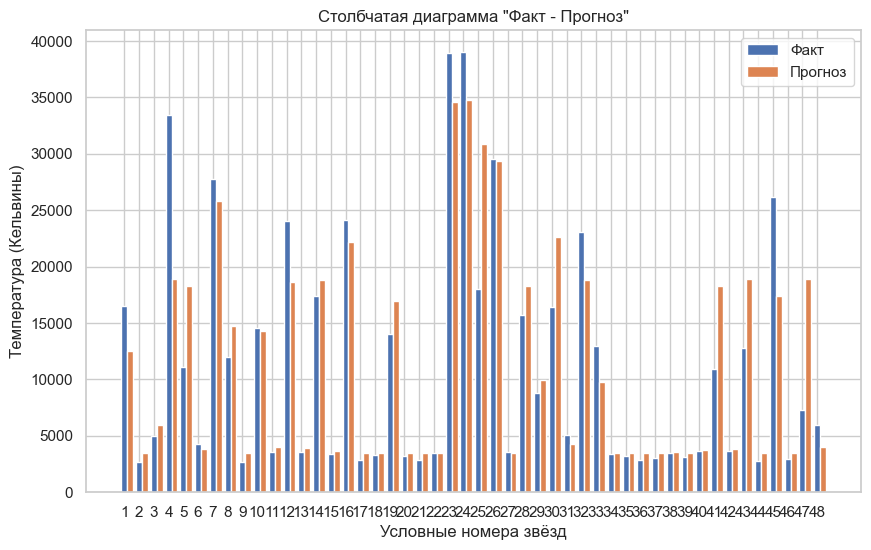

In [568]:
actual_values = y_test_tensor.numpy().flatten()
predicted_values = best_predict
# условные номера звезд
star_numbers = range(1, len(actual_values) + 1)

bar_width = 0.4 # ширина столбцов

plt.figure(figsize=(10, 6))
plt.bar(star_numbers, actual_values, width=bar_width, label='Факт', align='center')
plt.bar(np.array(star_numbers) + bar_width, predicted_values, width=bar_width, label='Прогноз', align='center')
plt.xlabel('Условные номера звёзд')
plt.ylabel('Температура (Кельвины)')
plt.title('Столбчатая диаграмма "Факт - Прогноз"')
plt.legend()
plt.grid(True)
plt.xticks(star_numbers)
plt.show()

<div style="padding: 30px 25px; border: 2px #6495ed solid">
    
    - Метрика качества модели после применения подбора параметров нейронной сети, на тестовых данных составила 4389, что соответствует заявленному минимуму.
    - По графику "Факт - Прогноз" видно, что модель стала лучше предсказывать температуру наиболее горячих звезд, по сравнению с простой моделью.
    - Оптимальные параметры:
        - 'dropout': 0.5
        - 'batch_size': 8
    
</div>

<div style="padding:0px 20px 10px; 
            color:#004346;
            font-size:15px;
            display:fill;
            text-align:center;
            border-radius:20px;
            border: 5px double;
            border-color:#201E20;
            background-color: #E8F1F2;
            overflow:hidden;
            font-weight:400"> 

# Вывод
    
</div>

- Проведен анализ и предобработка данных.
- Разработаны и проверены на данных для тестирования две нейронные сети.
- Достигнута удовлетворяющая метрика качества (4389).
- Во второй модели проведен подбор параметров размера пакета (батча) и Dropout, без изменений в архитектуре сети:

   - Оптимальный размера пакета (батча) составил 8, что ниже по сравнению размера батча в исходной модели, что имеет плюсы:
       - Ускорение обучения: Уменьшение размера пакета позволяет обновлять веса модели чаще, поскольку каждая эпоха будет иметь больше итераций. Это может привести к ускорению процесса обучения и быстрому сходимости модели.

       - Экономия памяти: Меньший размер пакета требует меньше оперативной памяти для хранения активаций и градиентов.

       - Более стабильное обновление весов: Уменьшение размера пакета может сделать обновление весов более стабильным и надежным, поскольку каждое обновление основано на меньшем числе образцов данных. Это может помочь предотвратить большие колебания в процессе обучения и повысить стабильность модели.
       
   - Преимущества применения метода Dropout:

        - Dropout помогает уменьшить взаимозависимость между нейронами в сети, поскольку каждый нейрон может быть случайным образом отключен. Это позволяет модели изучать более разнообразные представления данных и уменьшает риск сильной корреляции между нейронами.

        - Модель становится более устойчивой к шуму в данных. Это может помочь улучшить обобщающую способность модели, то есть ее способность делать точные прогнозы на новых, неизвестных данных.
 __________       
- __Рекомендации:__
     - Необходим сбор дополнительных данных, что позволит построить модель с большей точностью прогнизирования.

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>
    
Немного полезного материала:    

1) Ребята из-за "бугра": https://www.reg.ru/blog/stenfordskij-kurs-lekciya-1-vvedenie/ (тут про свёрточные, но интересно)<br>
2) Интересная статья специалиста Тесла: https://karpathy.github.io/neuralnets/ <br>
3) Список книг на выбор: https://habr.com/ru/company/neurodatalab/blog/336218/ <br>



Кстати есть еще нейросеть TabNet, которая заточена для работы с табличными данными:
+  https://habr.com/ru/post/540736/    
+  https://www.kaggle.com/code/carlmcbrideellis/tabnet-a-very-simple-regression-example/notebook

</div>

<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b> 
    
Еще можно было вот так решить:
    
+  https://colab.research.google.com/drive/1ZyMsfYf5c1jzBurRKMIlF8n6Vmn7Lpad?usp=sharing

</div>


<font color='blue'><b>Итоговый комментарий ревьюера</b></font>
<div class="alert alert-success">
<b>Комментарий ревьюера ✔️:</b>Денис, спасибо за хороший проект!!! Я готов принять работу, но хочу убедиться, что тебе все понятно.<br>
Если есть какие либо вопросы я с удовольствием на них отвечу:)</div>
